# Set up -- just run all this stuff

In [1]:
from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
import pickle
import os
import torch as t
from circuits.chess_utils import decode_list
from IPython.display import HTML
from circuits.chess_utils import pgn_string_to_board
from circuits.nnsight_buffer import NNsightActivationBuffer
import circuits.othello_utils as othello_utils
from huggingface_hub import hf_hub_download
from circuits.utils import (
    chess_hf_dataset_to_generator,
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)
import matplotlib.pyplot as plt

repo_dir = '/home/can/chess-gpt-circuits'

# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/group-2024-05-17_othello'):
    hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='group-2024-05-17_othello.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/group-2024-05-17_othello.zip -d autoencoders')


device = 'cuda:0'

In [2]:
# load SAE
ae_type = 'standard_new'
trainer_id = 0

ae_path = f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{ae_type}/trainer{trainer_id}'
if ae_type == 'standard':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

# load information about features
with open(os.path.join(ae_path, 'indexing_find_dots_indices_n_inputs_1000_feature_labels.pkl'), 'rb') as f:
    results = pickle.load(f)

def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
results = to_device(results)



# load model
layer = 5
othello = True

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

model = get_model(model_name, device)
submodule = get_submodule(model_name, layer, model)

# load data
activation_dim = 512  # output dimension of the layer
buffer = NNsightActivationBuffer(
    data,
    model,
    submodule,
    n_ctxs=8e3,
    ctx_len=context_length,
    refresh_batch_size=128,
    io="out",
    d_submodule=activation_dim,
    device=device,
)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


In [3]:
n_inputs = 10
batch_size = 128
import circuits.eval_sae_as_classifier as eval_sae


custom_functions = [othello_utils.games_batch_to_state_stack_mine_yours_BLRRC]

data = eval_sae.construct_dataset(
    othello, custom_functions, n_inputs,
    split="train", device=device)

data, ae_bundle, pgn_strings, encoded_inputs = eval_sae.prep_firing_rate_data(
        ae_path+"/", batch_size, "", model_name, data, device, n_inputs, othello
    )
ae_bundle.buffer = None
data = data['games_batch_to_state_stack_mine_yours_BLRRC']

Evaluating on layer:  5
Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


In [4]:
game_idx = 0
move_idx = 30
board_state_RRC = data[game_idx][move_idx]
board_state_RR = t.argmax(board_state_RRC, dim=-1) - 1

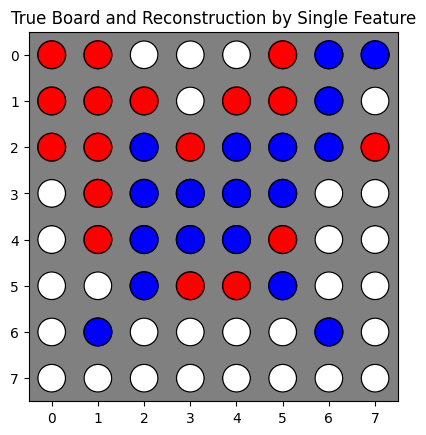

In [5]:
non_classified_idx = -2

def plot_comparison_othello_board(true_board_RR, recon_board_RR=None):
    """
    Plots a comparison of the true and reconstructed Othello boards using matplotlib.

    Args:
    true_board (torch.Tensor): A 2D tensor representing the true Othello board.
    recon_board (torch.Tensor): A 2D tensor representing the reconstructed Othello board.
    """

    if recon_board_RR is None:
        recon_board_RR = t.ones_like(true_board_RR) * non_classified_idx

    # Create a color map based on the unique labels in the board
    color_map = {non_classified_idx: 'grey', -1: 'red', 0: 'white', 1: 'blue'}
    cmap = plt.matplotlib.colors.ListedColormap(color_map.values())

    board_indices = recon_board_RR.numpy() - min(color_map.keys())


    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    plt.imshow(board_indices, cmap=cmap)
    # add circles on each square with black borders
    for i in range(8):
        for j in range(8):
            circle = plt.Circle((j, i), 0.3, color=color_map[true_board_RR[i, j].item()], fill=True)
            circle_edges = plt.Circle((j, i), 0.3, color='black', fill=False)
            plt.gca().add_artist(circle)
            plt.gca().add_artist(circle_edges)
            if recon_board_RR[i, j].item() != non_classified_idx:
                plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=2))
    plt.title('True Board and Reconstruction by Single Feature')
    # plt.savefig('othello_board_comparison.png', dpi=300)
    plt.show()

plot_comparison_othello_board(board_state_RR.to('cpu'))

In [6]:
# functions for visualizing PNG string
def shade(value, max_value):
    if abs(value) > max_value:
        raise ValueError("Absolute value must be less than or equal to max_value.")
    
    normalized_value = value / max_value
    
    if normalized_value < 0:
        # Red shade for negative values
        red = 255
        green = int(255 * (1 + normalized_value))
        blue = int(255 * (1 + normalized_value))
    else:
        # Blue shade for positive values
        red = int(255 * (1 - normalized_value))
        green = int(255 * (1 - normalized_value))
        blue = 255
    
    # White color for zero value
    if value == 0:
        red = green = blue = 255
    
    # Convert RGB values to hex color code
    hex_color = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    return hex_color

def visualize_pgn(tokens, meta, activations, max_value, prefix=''):
    html_elements = []
    for token, act in zip(tokens, activations):
        hex_color = shade(act, max_value)
        s = decode_list(meta, [token])[0]
        s = s.replace(' ', '&nbsp;')
        html_element = f'<span style="background-color: {hex_color}; color: black">{s}</span>'
        html_elements.append(html_element)
    
    combined_html = ''.join(html_elements)
    combined_html = prefix + combined_html
    return HTML(combined_html)

In [7]:
# # visualize top k max activating contexts for given feature
# def visualize(model, ae, buffer, feat_idx, k=20):
#     tokens = buffer.token_batch()
#     with model.trace(tokens, scan=False, validate=False): # use_cache=False,  output_attentions=False
#         embeds = model.unembed.output.save()
#         embeds.retain_grad()
#         x = submodule.output[0]
#         f = ae.encode(x).save()
#     mean_embed = embeds.value.mean(dim=(0,1))
#     f = f.value[...,feat_idx]

#     # get indices of top k exemplars

#     flattened_f = f.flatten()
#     top_values, top_indices_flattened = t.topk(flattened_f, k)
#     print(top_indices_flattened)
#     top_indices = t.unravel_index(top_indices_flattened, f.shape)
#     top_values.sum().backward()

#     # compile top contexts and activations
#     contexts, activations, attributions = [], [], []
#     for i in range(k):
#         context_idx, token_idx = top_indices[0][i].item(), top_indices[1][i].item()
#         contexts.append(tokens[context_idx, :token_idx+1].tolist())
#         activations.append(f[context_idx, :token_idx+1].tolist())
#         attributions.append(
#             (embeds.value.grad * (embeds.value - mean_embed)).sum(dim=-1)[context_idx, :token_idx+1].tolist()
#         )
#     max_value = max([abs(x) for act in activations for x in act] + [abs(x) for att in attributions for x in att])

#     for context, activation, attribution in zip(contexts, activations, attributions):
#         pgn_string = decode_list(meta, context)
#         display(visualize_pgn(context, meta, activation, max_value, prefix='feature activations: '))
#         display(visualize_pgn(context, meta, attribution, max_value, prefix='promoting tokens: '))
#         print('most recent valid board:')
#         while pgn_string:
#             try:
#                 display(pgn_string_to_board(pgn_string))
#                 break
#             except:
#                 pgn_string = pgn_string[:-1]

# Here's the interactive part

Key for mapping from the last entry of the board state tensor to pieces:
* 0 => black king
* 1 => black queen
* 2 => black rook
* 3 => black bishop
* 4 => black knight
* 5 => black pawn
* 6 => empty
* 7 => white pawn
* 8 => white knight
* 9 => white bishop
* 10 => white rook
* 11 => white queen
* 12 => white king

In [8]:
# set idx to be the index of the (alive) feature you want to visualize
idx = 4
feat_idx = results['alive_features'][idx]
# print("Board states that the feature classifies according to Adam's measurements:")
# print((results['board_to_piece_state'][0][idx] > .95).nonzero())
# print("Number of such board states:")
# print((results['board_to_piece_state'][0][idx] > .95).sum())
# visualize(model, ae, buffer, feat_idx, k=20)

In [9]:
k = 20
feat_idx = 4

tokens = buffer.token_batch()
with model.trace(tokens, scan=False, validate=False): # use_cache=False,  output_attentions=False
    embeds = model.hook_embed.output.save()
    embeds.retain_grad()
    x = submodule.output
    f = ae.encode(x).save()
mean_embed = embeds.value.mean(dim=(0,1))
f = f.value[...,feat_idx]

# get indices of top k exemplars

def unravel_index(indices, shape):
    out = []
    for dim in reversed(shape):
        out.append(indices % dim)
        indices = indices // dim
    return tuple(reversed(out))

flattened_f = f.flatten()
top_values, top_indices_flattened = t.topk(flattened_f, k)
top_indices = unravel_index(top_indices_flattened, f.shape)
top_values.sum().backward()

# compile top contexts and activations
contexts, activations, attributions = [], [], []
for i in range(k):
    context_idx, token_idx = top_indices[0][i].item(), top_indices[1][i].item()
    contexts.append(tokens[context_idx, :token_idx+1].tolist())
    activations.append(f[context_idx, :token_idx+1].tolist())
    attributions.append(
        (embeds.value.grad * (embeds.value - mean_embed)).sum(dim=-1)[context_idx, :token_idx+1].tolist()
    )
max_value = max([abs(x) for act in activations for x in act] + [abs(x) for att in attributions for x in att])

# for context, activation, attribution in zip(contexts, activations, attributions):
#     pgn_string = decode_list(meta, context)
#     display(visualize_pgn(context, meta, activation, max_value, prefix='feature activations: '))
#     display(visualize_pgn(context, meta, attribution, max_value, prefix='promoting tokens: '))
#     print('most recent valid board:')
#     while pgn_string:
#         try:
#             display(pgn_string_to_board(pgn_string))
#             break
#         except:
#             pgn_string = pgn_string[:-1]

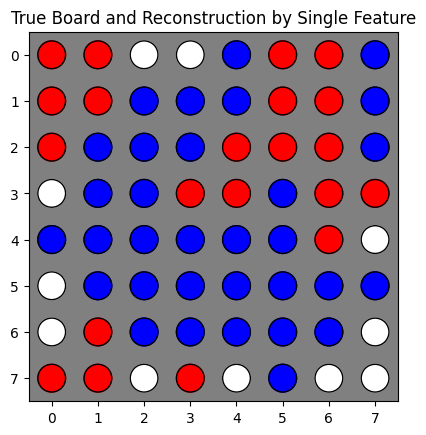

In [17]:
# visualize othello board for top activating example
context, activation, attribution = contexts[0], activations[0], attributions[0]
context_s = [othello_utils.itos[s] for s in context]
board_state_RR = othello_utils.games_batch_to_state_stack_mine_yours_BLRRC([context_s])[0][-1]
board_state_RR = t.argmax(board_state_RR, dim=-1) - 1
plot_comparison_othello_board(board_state_RR.to('cpu'))

In [21]:
len(activation)

49

In [15]:
embeds.value.shape

torch.Size([128, 59, 61])

In [16]:
embeds.value.grad is None

True

In [17]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hoo